## Import necessary Libraries

In [6]:
import torch
from torchvision import datasets, transforms
from torch import nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import helper
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

### Obtain datasets

In [8]:
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.5,),(0.5,))])

trainset = datasets.FashionMNIST('../datasets/',train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)

testset = datasets.FashionMNIST('..datasets/',train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, shuffle=True, batch_size=64)

100.0%

Extracting ../datasets/FashionMNIST\raw\train-images-idx3-ubyte.gz to ../datasets/FashionMNIST\raw


111.0%

Extracting ../datasets/FashionMNIST\raw\train-labels-idx1-ubyte.gz to ../datasets/FashionMNIST\raw


100.0%

Extracting ../datasets/FashionMNIST\raw\t10k-images-idx3-ubyte.gz to ../datasets/FashionMNIST\raw


159.1%

Extracting ../datasets/FashionMNIST\raw\t10k-labels-idx1-ubyte.gz to ../datasets/FashionMNIST\raw
Processing...
Done!


100.0%

Extracting ..datasets/FashionMNIST\raw\train-images-idx3-ubyte.gz to ..datasets/FashionMNIST\raw


111.0%

Extracting ..datasets/FashionMNIST\raw\train-labels-idx1-ubyte.gz to ..datasets/FashionMNIST\raw


100.0%

Extracting ..datasets/FashionMNIST\raw\t10k-images-idx3-ubyte.gz to ..datasets/FashionMNIST\raw


159.1%

Extracting ..datasets/FashionMNIST\raw\t10k-labels-idx1-ubyte.gz to ..datasets/FashionMNIST\raw
Processing...
Done!


torch.Size([64, 1, 28, 28])


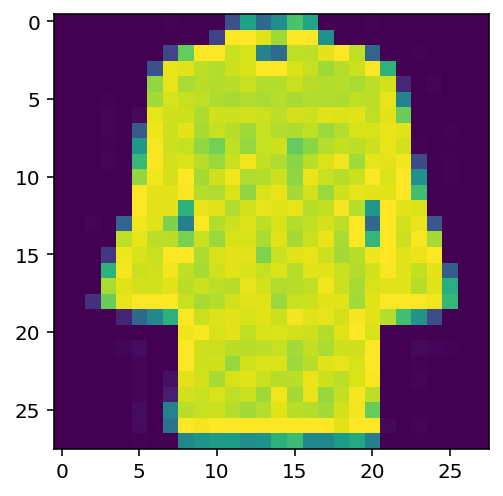

In [19]:
# Viewing an image from the datasets
image, label = next(iter(trainloader))
plt.imshow(image[0].view(image.shape[2],-1))
print(image.shape)